# Projeto Data Mining II - Colorectal Cancer

## 1: Import libraries and Data

In [76]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [77]:
# This script downloads a CSV file from a given URL and loads it into a pandas DataFrame.
url = "https://raw.githubusercontent.com/rgerc8/dm2-class-cancer/9bc81e82c839d3a4b14415d5bbd448452adad0f8/DM2%20Project%20Datasets/patient_train_data.csv"
df_original = pd.read_csv(url)
df = df_original.copy()

## 2: Exploratpry Data Analysis (EDA)

In [80]:
df.shape #(75035, 32)

(75035, 32)

In [81]:
df.head(5)
#df.tail(5)
#df.describe().T
#df.describe(include = ['O']).T
#df.info()
#df.columns
#df.isna().sum()

,ID,Alcohol Consumption,Cancer Stage,Country,Date of Birth,Diabetes,Diabetes History,Diet Risk,Early Detection,Family History,...,Non Smoker,Obesity BMI,Physical Activity,Screening History,Smoking History,Transfusion History,Treatment Type,Tumor Size (mm),Urban or Rural,Survival Prediction
0,1,No,Localized,UK,29-01-1966,No,No,Moderate,No,No,...,Yes,Overweight,Low,Regular,No,-,Chemotherapy,33.0,Urban,Yes
1,2,No,Regional,Japan,21-12-1958,No,No,Low,No,No,...,No,Normal,Low,Irregular,Yes,-,Chemotherapy,17.0,Urban,No
2,3,No,Localized,France,16-06-1959,No,No,Low,Yes,No,...,No,Normal,Moderate,Never,Yes,-,Surgery,34.0,Urban,Yes
3,4,Yes,Localized,Japan,18-01-1956,Yes,No,Moderate,No,No,...,Yes,Obese,Low,Regular,No,-,Radiotherapy,71.0,Urban,No
4,5,No,Regional,USA,04-05-1975,No,No,Moderate,Yes,Yes,...,Yes,Overweight,Low,Regular,No,-,Radiotherapy,48.0,Rural,Yes


In [ ]:
'''
df_numeric = df.select_dtypes(include='number')

for column in df_numeric.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_numeric[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()
'''

In [ ]:
df.drop(columns=['Marital Status'], inplace=True)
dfRows_no_missing = df.dropna()
print("The number of rows in the original insurance dataset is", df.shape[0])
print("The number of rows in the insurance dataset with no missing values is", dfRows_no_missing.shape[0])
print("There were", df.shape[0]-dfRows_no_missing.shape[0], "rows containing missing values.")


(75035, 31)

In [64]:
variavel = 'Healthcare Access'

print(len(df[variavel].unique()))
print(df[variavel].unique())
print(df[variavel].value_counts())
print(df[variavel].isna().sum())

5
['High' 'Moderate' 'Low' '?' nan]
Healthcare Access
Moderate    37197
High        22639
Low         15120
?              16
Name: count, dtype: int64
63


In [44]:
print(df.iloc[:, :10])

          ID Alcohol Consumption Cancer Stage       Country Date of Birth  \
0          1                  No    Localized            UK    29-01-1966   
1          2                  No     Regional         Japan    21-12-1958   
2          3                  No    Localized        France    16-06-1959   
3          4                 Yes    Localized         Japan    18-01-1956   
4          5                  No     Regional           USA    04-05-1975   
...      ...                 ...          ...           ...           ...   
75030  75031                 Yes    Localized         Italy    06-07-1972   
75031  75032                 Yes    Localized           USA    28-11-1954   
75032  75033                 Yes   Metastatic   South Korea    27-04-1963   
75033  75034                  No    Localized  South Africa    22-12-1951   
75034  75035                 Yes     Regional        France    23-07-1948   

      Diabetes Diabetes History Diet Risk Early Detection Family History  


In [47]:
print(df.iloc[:, 10:16])

      Gender Genetic Mutation Healthcare Access  Healthcare Costs  \
0          M               No              High           76553.0   
1          M               No          Moderate           62805.0   
2          M               No              High           66425.0   
3          M               No          Moderate           82764.0   
4          M               No               Low           47269.0   
...      ...              ...               ...               ...   
75030      M               No          Moderate           70574.0   
75031      M               No          Moderate           77430.0   
75032      M               No          Moderate          104820.0   
75033      F               No          Moderate          108752.0   
75034      M               No              High           68624.0   

      Heart Disease History Hypertension  
0                        No          Yes  
1                        No           No  
2                        No           No  

In [48]:
print(df.iloc[:, 16:22])

       Incidence Rate per 100K Inflammatory Bowel Disease Insurance Costs  \
0                         37.0                         No           Basic   
1                         54.0                        Yes    No insurance   
2                         15.0                        Yes        Extended   
3                         41.0                        Yes           Basic   
4                         23.0                         No           Basic   
...                        ...                        ...             ...   
75030                     58.0                         No    No insurance   
75031                     52.0                         No    No insurance   
75032                     44.0                         No           Basic   
75033                     32.0                         No    No insurance   
75034                     24.0                         No           Basic   

      Insurance Status  Marital Status  Mortality Rate per 100K  
0        

In [49]:
print(df.iloc[:, 22:28])

      Non Smoker Obesity BMI Physical Activity Screening History  \
0            Yes  Overweight               Low           Regular   
1             No      Normal               Low         Irregular   
2             No      Normal          Moderate             Never   
3            Yes       Obese               Low           Regular   
4            Yes  Overweight               Low           Regular   
...          ...         ...               ...               ...   
75030        Yes       Obese          Moderate           Regular   
75031        Yes  Overweight          Moderate           Regular   
75032        Yes       Obese               Low           Regular   
75033        Yes       Obese               Low             Never   
75034        Yes  Overweight              High         Irregular   

      Smoking History Transfusion History  
0                  No                   -  
1                 Yes                   -  
2                 Yes                   -  
3      

In [50]:
print(df.iloc[:, 28:])

      Treatment Type  Tumor Size (mm) Urban or Rural Survival Prediction
0       Chemotherapy             33.0          Urban                 Yes
1       Chemotherapy             17.0          Urban                  No
2            Surgery             34.0          Urban                 Yes
3       Radiotherapy             71.0          Urban                  No
4       Radiotherapy             48.0          Rural                 Yes
...              ...              ...            ...                 ...
75030   Chemotherapy             42.0          Urban                  No
75031   Chemotherapy             38.0          Urban                  No
75032        Surgery             60.0            NaN                 Yes
75033        Surgery             50.0          Rural                 Yes
75034    Combination             41.0          Urban                  No

[75035 rows x 4 columns]


In [ ]:
column_list = ['Alcohol Consumption', 'Cancer Stage', 'Country',
       'Diabetes', 'Diabetes History', 'Diet Risk', 'Early Detection',
       'Family History', 'Gender', 'Genetic Mutation', 'Healthcare Access',
       'Healthcare Costs', 'Heart Disease History', 'Hypertension',
       'Incidence Rate per 100K', 'Inflammatory Bowel Disease',
       'Insurance Costs', 'Insurance Status', 'Marital Status',
       'Mortality Rate per 100K', 'Non Smoker', 'Obesity BMI',
       'Physical Activity', 'Screening History', 'Smoking History',
       'Transfusion History', 'Treatment Type', 'Tumor Size (mm)',
       'Urban or Rural', 'Survival Prediction']

def inspect_columns_as_series(df, column_list):
    data = {}
    for column in column_list:
        unique_vals = df[column].unique()
        value_counts = df[column].value_counts(dropna=False).to_dict()
        nan_count = df[column].isna().sum()

        data[(column, 'Unique Values')] = unique_vals
        data[(column, 'Value Counts')] = value_counts
        data[(column, 'NaN Count')] = nan_count

    return pd.Series(data)

In [16]:
df.skew(numeric_only=True)

ID                         0.000000
Healthcare Costs          -0.001733
Incidence Rate per 100K    0.027104
Marital Status                  NaN
Mortality Rate per 100K   -0.005866
Tumor Size (mm)            0.021154
dtype: float64

In [18]:
df.kurtosis(numeric_only=True)

ID                        -1.200000
Healthcare Costs          -1.086328
Incidence Rate per 100K   -1.075704
Marital Status                  NaN
Mortality Rate per 100K   -1.158039
Tumor Size (mm)           -1.093692
dtype: float64

In [19]:
df.corr(method='pearson', numeric_only=True)

,ID,Healthcare Costs,Incidence Rate per 100K,Marital Status,Mortality Rate per 100K,Tumor Size (mm)
ID,1.000000,0.002549,0.003406,NaN,0.003539,-0.001101
Healthcare Costs,0.002549,1.000000,0.003471,NaN,-0.003858,0.000513
Incidence Rate per 100K,0.003406,0.003471,1.000000,NaN,0.003927,0.000228
Marital Status,NaN,NaN,NaN,NaN,NaN,NaN
Mortality Rate per 100K,0.003539,-0.003858,0.003927,NaN,1.000000,-0.000756
Tumor Size (mm),-0.001101,0.000513,0.000228,NaN,-0.000756,1.000000


<Axes: >

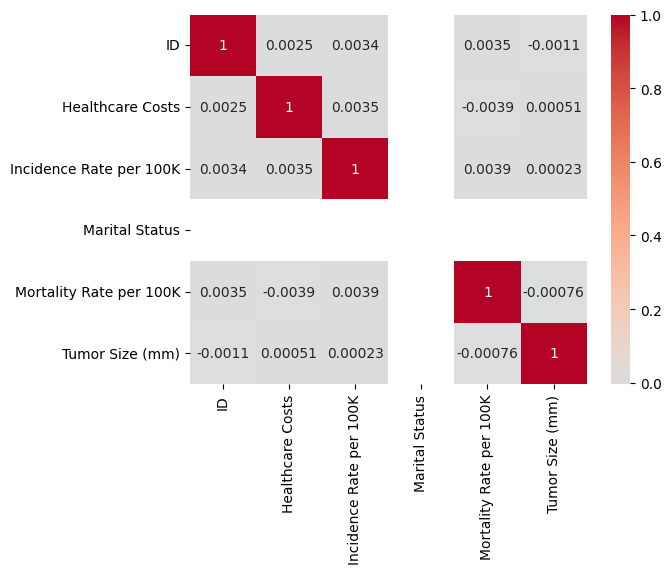

In [21]:
#sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', center=0)


In [33]:
pd.crosstab(df["Cancer Stage"], df["Diabetes History"], margins=True)
#df["Cancer Stage"].value_counts()
#df["Diabetes History"].value_counts()

Diabetes History,No,Yes,All
Cancer Stage,,,
Localized,29817,3,29820
Metastatic,15319,1,15320
Regional,29876,6,29882
All,75012,10,75022
